
# sinc(x, y)

$
1-\; we'll\;draw\;the \;function
\\2-\; simulating\; it\; using\; ANFIS
\\3- simulating\; it \;using\; NN
$
$$
z = \text{sinc}(x,y) = \frac{\sin(x)\sin(y)}{xy}
$$

# Part 1

In [11]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

<IPython.core.display.Javascript object>


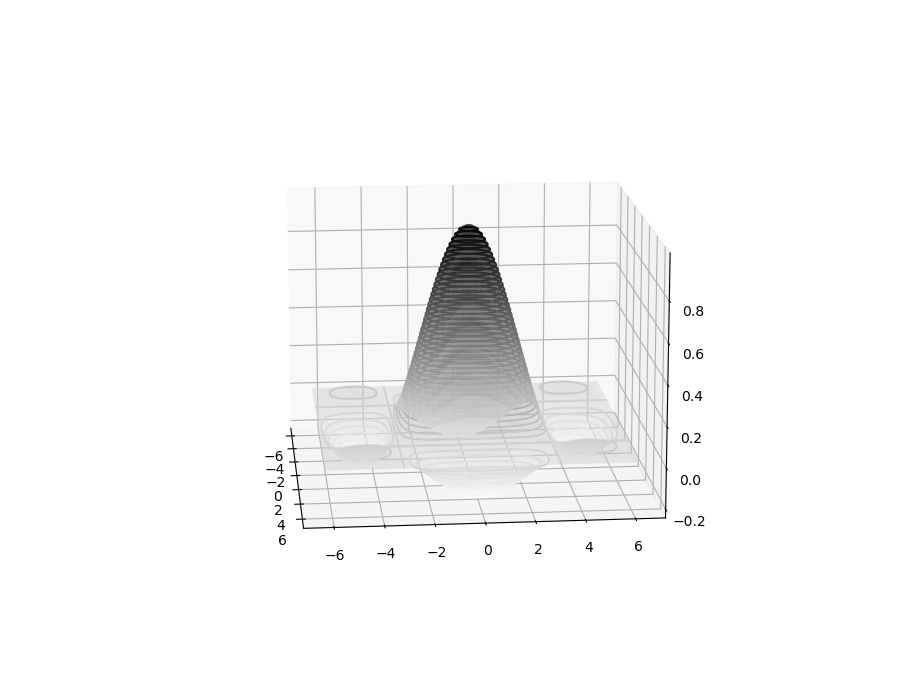

In [12]:
%matplotlib notebook

fig = plt.figure(figsize = (9,7))
ax = plt.axes(projection='3d')

n = 300
X = np.linspace(-2*np.pi,2*np.pi,n)
Y = np.linspace(-2*np.pi,2*np.pi,n)
XX,YY = np.meshgrid(X,Y)
ZZ = np.sin(XX)*np.sin(YY)/(XX*YY)
ax.contour3D(XX,YY,ZZ,50,cmap='binary')
ax.plot_surface(XX,YY,ZZ,alpha=0.5,cmap='binary')
ax.view_init(30,15)
plt.show()

# Part 2